In [1]:
import h5py
with h5py.File("__run__/CE_Bavera_2020.h5", "r") as hf:
    theta_true = hf["test_theta"][()]
    m1, m2 = theta_true[:,0], theta_true[:, 1]
    m2_c = m2.copy()
    m1_c = m1.copy()
    m1[m1<m2] = m2[m1<m2]
    m2[m1_c<m2_c] = m1_c[m1_c<m2_c]
    chi=theta_true[:,-2]
    mc = ((m1*m2)**(3.0/5.0))/((m1+m2)**(1.0/5.0))
    q = m2/m1

In [2]:
import matplotlib
from matplotlib.transforms import Bbox
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
colors=sns.color_palette('colorblind')
fs=28
import numpy as np

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import tqdm
import pandas as pd
np.random.seed(69)
model_file = '/home/anarya.ray/sbi/models_reduced.hdf5'
lambdas = [ ]
thetas = [ ]
chi_bs=np.array([0.0,0.1,0.2,0.5])
alphas = np.array([0.2,0.5,1.0,2.0,5.0])
n_cbc_per_pop = 1000000
test_chib = 0.1
test_alpha = 1.0
chi_bs, alphas = np.meshgrid(chi_bs,alphas)
chi_bs, alphas = chi_bs.flatten(),alphas.flatten()

ignore_alphas = [100,200]
ignore_chi_bs = [100.1,100.2]
for i,(this_chib, this_alpha) in enumerate(zip(tqdm.tqdm(chi_bs),alphas)):
    if this_alpha<1:
        alpha_key = f'0{int(this_alpha*10)}'
    else:
        alpha_key = f'{int(this_alpha)}0'
    if this_alpha == test_alpha and test_chib == this_chib:
        pass
    else:
        continue
    df_CE = pd.read_hdf(model_file,key=f'CE/chi0{int(this_chib*10.)}/alpha'+alpha_key)
    events_CE = np.concatenate(tuple([df_CE[param].to_numpy()[:,None] for param in ["m1", "m2", "chieff", "z"]]), axis = -1)
    N = int(1e6) #min(len(np.where(df_CE['weight'].to_numpy()>0)[0]), n_cbc_per_pop)
    print(N, n_cbc_per_pop)
    this_thetas = events_CE[np.random.choice(np.arange(len(events_CE)), p=df_CE['weight'].to_numpy()/sum(df_CE['weight'].to_numpy()),
                                             size = N, replace = True), :]
    this_lambdas = np.array([[this_chib, this_alpha]])*(np.ones(n_cbc_per_pop)[:,None])
    
    data_true = this_thetas.copy()
    
    


  0%|          | 0/20 [00:00<?, ?it/s]

1000000 1000000


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


In [4]:
data_true.shape

(1000000, 4)

In [132]:
np.savetxt('dense_test_set.txt', data_true )

In [5]:
m1ut, m2ut = data_true[:,0], data_true[:, 1]
xmin,xmax= 2.3, 22.0
m2_c = m2ut.copy()
m1_c = m1ut.copy()
m1ut[m1ut<m2ut] = m2ut[m1ut<m2ut]
m2ut[m1_c<m2_c] = m1_c[m1_c<m2_c]
chiut=data_true[:,-2]
mcut = ((m1ut*m2ut)**(3/5))/((m1ut+m2ut)**(1/5))
qut = m2ut/m1ut

In [6]:
samps = np.loadtxt('/home/anarya.ray/jaxflows/paper/naz/examples/papers/1/amplified_samples.txt')
m1,m2,chiamp = np.exp(samps[:,0]), np.exp(samps[:,1]), samps[:,2]
mcamp = ((m1*m2)**(3/5))/((m1+m2)**(1/5))
qamp = m2/m1
qamp[qamp>1] = 1/qamp[qamp>1]



In [7]:
qmax = 0.3
chimax = 0.8
mcmin = 6
mcmax = 100
argf = (qamp<qmax)*(mcamp<mcmax)*(mcamp>mcmin)*(chiamp<chimax)#*(chiamp>ymin)*(chiamp<ymax)*
print(len(mcamp[argf]))
argut = (qut<qmax)*(mcut>mcmin)*(mcut<mcmax)*(chiut<chimax)
print(len(mcut[argut]))
arg = (q<qmax)*(mc<mcmax)*(mc>mcmin)*(chi<chimax)#*(chi>ymin)*
print(len(mc[arg]))

1140
772
7


In [8]:
nbins = 15
mcbin = np.linspace(mcmin,15,nbins)
chibin = np.linspace(chiut.min(), 0.8, nbins)

(-0.07199862210581326, 0.7677037547368217)


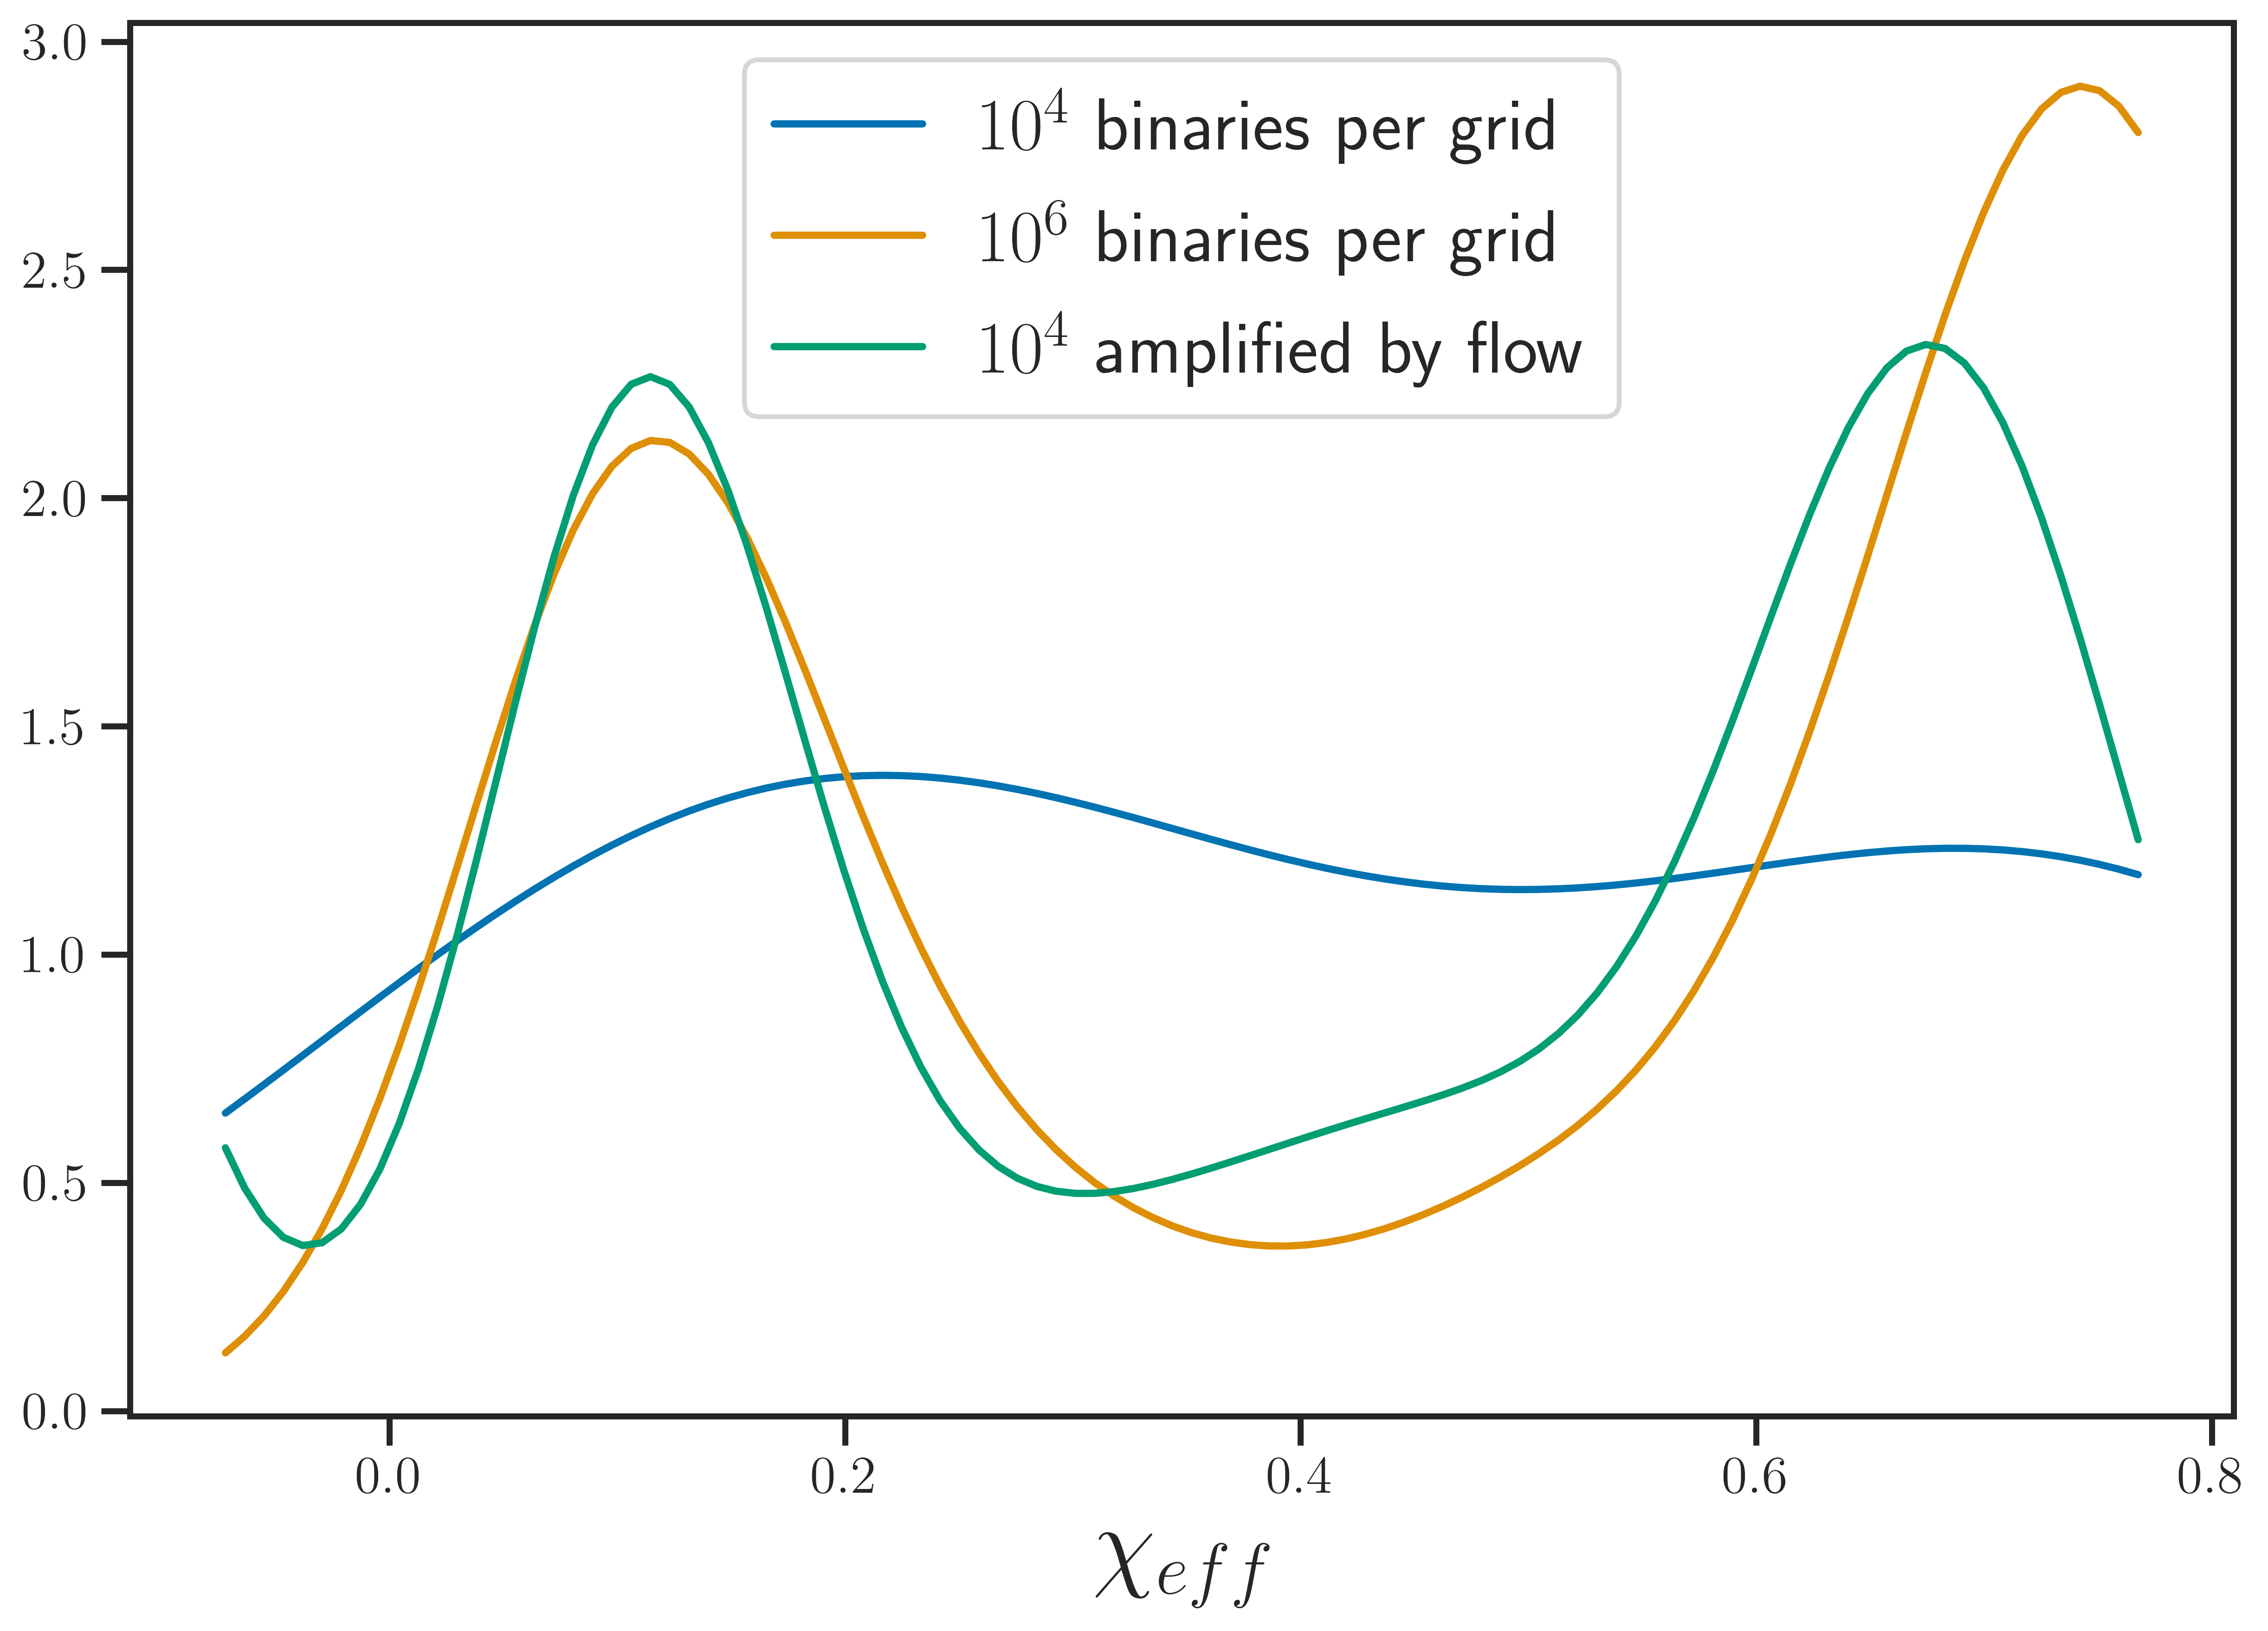

In [12]:
fig,ax = plt.subplots(1, figsize=(9*1.3,6*1.3), dpi =500)

from scipy.stats import gaussian_kde
x = 0.5*(chibin[1:]+chibin[:-1])
bounds = (x.min(), x.max())
print(bounds)
X = np.linspace(x.min(),x.max(),100)
ar = (X<bounds[0]) + (X>bounds[1])

kde = gaussian_kde(chi[arg])
y = kde.pdf(X)
#y+=kde.pdf(bounds[0]-X)
#y[ar] = 0.0
y/=np.trapz(y,X)
_=ax.plot(X, y, label = r"$10^4$ binaries per grid")



kde = gaussian_kde(chiut[argut])
y = kde.pdf(X)
#y+=kde.pdf(bounds[0]-X)
#y[ar] = 0.0
y/=np.trapz(y,X)
_=ax.plot(X, y, label = r"$10^6$ binaries per grid")

kde = gaussian_kde(chiamp[argf])
y = kde.pdf(X)
y+=kde.pdf(bounds[0]-X)
y/=np.trapz(y,X)
_=ax.plot(X, y, label = r"$10^4$ amplified by flow")
ax.legend(fontsize = 23, loc = "upper center")
ax.set_xlabel(r"$\chi_{eff}$", fontsize = 32)
fig.savefig('amp.png', dpi=500,)
plt.show()